# Set input image from Google drive

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# input_path = "/content/drive/Shareddrives/Yolab - Current Projects/Emilie/z-stacking/For Emilie/LG-19/Single Slices (z-stack)/y0050.tiff"
input_path = "/content/drive/Shareddrives/Yolab - Current Projects/Danny - Zero Shot Learning on OCT/OCT Image Examples (to Stitch)/Test-compression/Test-8 (compressed gel)/test8-scan8_0001_Mode2D.tiff"

# Set Up Environment

In [61]:
model_folder = "/content/drive/Shareddrives/Yolab - Current Projects/Emilie/z-stacking/For Emilie/LE-03/Single non z-stack slices/LE-03_StackVolume_Iteration2_50.jpg"

In [62]:
model_folder = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Model (Paper V2)"

import os

# Import pix2pix code from github
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

# Go to the directory where our model lives
%cd /content/pytorch-CycleGAN-and-pix2pix/

# From the requirements folder we are installing:
!pip install -r /content/pytorch-CycleGAN-and-pix2pix/requirements.txt

fatal: destination path 'pytorch-CycleGAN-and-pix2pix' already exists and is not an empty directory.
/content/pytorch-CycleGAN-and-pix2pix


In [63]:
# Copy model to this folder over
!mkdir checkpoints
!mkdir checkpoints/pix2pix/
!cp "{model_folder}/latest_net_G.pth" checkpoints/pix2pix/
!cp "{model_folder}/latest_net_D.pth" checkpoints/pix2pix/

mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘checkpoints/pix2pix/’: File exists


# Preprocess image

Some helper functions:

In [64]:
import cv2
import matplotlib.pyplot as plt

def showImgByPath(path):
  """Show the image for filepath <path>"""
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.figure()
  plt.imshow(image)

def readImgByPath(path):
  """Return the image for filepath <path> """
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def showImg(image):
  """Show the image, which content is in image."""
  plt.figure()
  plt.imshow(image)

def showTwoImgs(img1, img2):
  """Show both images, side by side."""
  plt.subplot(1,2,1);
  plt.imshow(img1);
  plt.subplot(1,2,2);
  plt.imshow(img2);

def get_first_zero_and_next_non_zero_idx(arr):
  """
  For an input array <arr>, returns the first zero index i_0, and the next non-zero index i_1 > i_0.
  """
  first_zero = (arr==0).argmax()
  tmp = np.copy(arr);
  tmp[:first_zero] = 0
  next_non_zero = (tmp>0).argmax(axis=0)
  return first_zero, next_non_zero

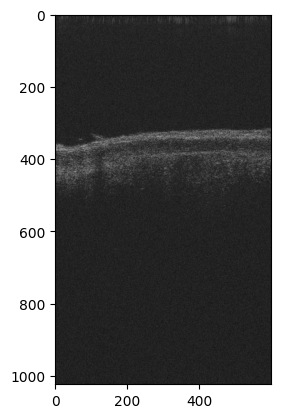

In [65]:
#a new image from
path_new_image = input_path;
showImgByPath(path_new_image);
img = readImgByPath(path_new_image);

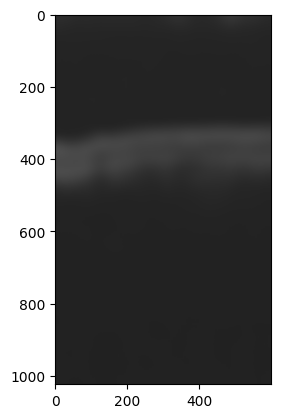

In [66]:
# First we apply a gaussian filter to smooth everything, it will help make the thresholding smoother
import numpy as np;
import cv2;

sigma = 20;
#the default filter size in Matlab
filter_size = int(2*np.ceil(2*sigma)+1);
filt_img = cv2.GaussianBlur(img,(filter_size,filter_size),sigma)
showImg(filt_img)

In [67]:
# First we average over x axis (rows) to get one value for each depth
m_mean = np.nanmean(filt_img,axis=1);
print(m_mean.shape)
print(m_mean)

(1024, 3)
[[43.72666667 43.72666667 43.72666667]
 [43.74       43.74       43.74      ]
 [43.72333333 43.72333333 43.72333333]
 ...
 [33.86833333 33.86833333 33.86833333]
 [33.865      33.865      33.865     ]
 [33.86166667 33.86166667 33.86166667]]


In [68]:
# Then we figure out what is the "brightest" row by taking percentile:
m_mean_max = np.percentile(m_mean, 99, axis=0)
print(m_mean_max.shape)
print(m_mean_max)

(3,)
[65.84005 65.84005 65.84005]


In [69]:
# Then we figure out what is the noise floor of the device, by examining the bottom 50 rows of OCT image
m_mean_min = np.mean(m_mean[-50:]);
print(m_mean_min.shape)
print(m_mean_min)

()
33.848233333333326


In [70]:
# Finally we define a threshold for OCT intensity, anything below that will be blacked out
minSignal = 0.28 * (m_mean_max - m_mean_min) + m_mean_min;

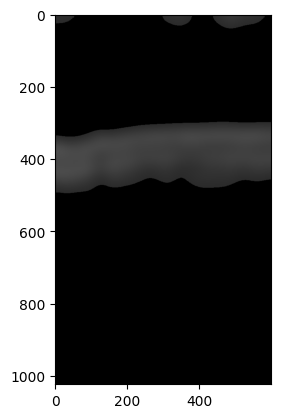

In [71]:
filt_img[filt_img<minSignal] = 0;
showImg(filt_img)

Assuming the top and bottom 10% of the mask should be black:

102 921


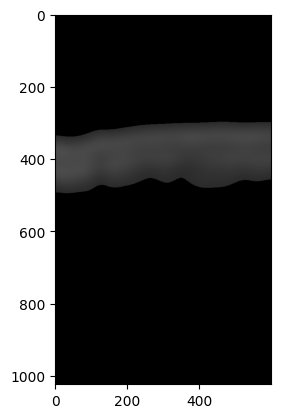

In [72]:
p = 0.1
print(int(p*height), int((1-p)*height))
height = filt_img.shape[0]
filt_img[0:int(p*height),:]=0
filt_img[int((1-p)*height):,:]=0
showImg(filt_img)

rows indicating black segments in image:
0 298
1024 496


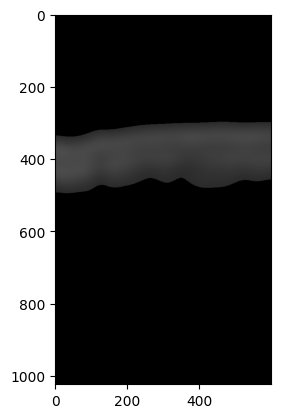

In [74]:
# get mean over x axis (rows) to get one value for each depth, for new thresholded image.
m_mean = np.nanmean(filt_img,axis=1);

#assume there's a non-black area around the middle of the image, surrounded by black area.
#Find the first black line, and the next non black line.
m_mean_arr = np.copy(m_mean[:,0])
print("rows indicating black segments in image:")
first_zero, next_non_zero = get_first_zero_and_next_non_zero_idx(m_mean_arr);
print(first_zero, next_non_zero)

#Do the same to the vertically flipped (mirrored around the x axis) image.
flipped = np.copy(np.flip(m_mean_arr))
first_zero_from_the_end, next_non_zero_from_the_end = get_first_zero_and_next_non_zero_idx(flipped);
h = len(flipped)
first_zero_from_the_end = h - first_zero_from_the_end
next_non_zero_from_the_end = h - next_non_zero_from_the_end
print(first_zero_from_the_end, next_non_zero_from_the_end)
showImg(filt_img)

288 506


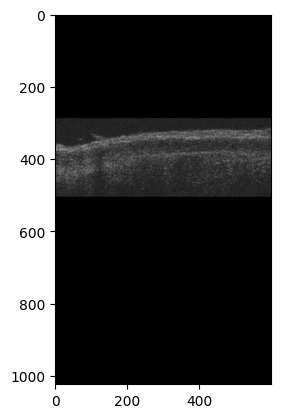

In [75]:
# "Blackout" everything above and below the tissue-gel interface
margin = 10; #margin around the high-enough-snr area.
top = next_non_zero - margin;
bottom = next_non_zero_from_the_end + margin;
print(top,bottom)
img[:top,:] = 0
img[bottom:,:] = 0
showImg(img)

In [76]:
top

288

In [77]:
# img[img==255] = 254;
# img = img+1;
# img[img<minSignal] = 0;
# showImg(img)

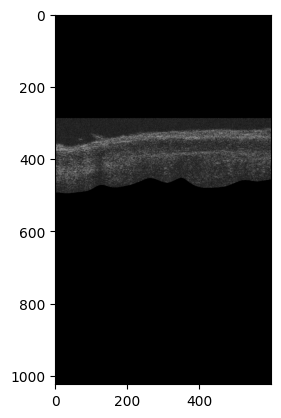

In [78]:
mid = int((bottom+top)/2.0);
filt_img[:mid,:] = 1;
img[filt_img==0 ] = 0;
showImg(img)

397


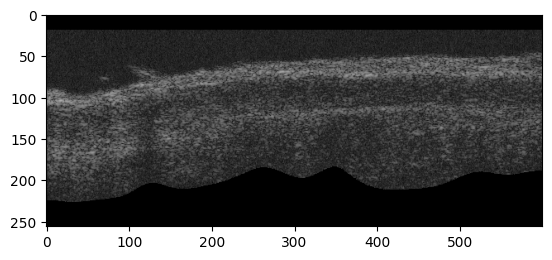

In [79]:
mid = int((bottom+top)/2.0)
print(mid)
cropped_img = img[mid-128:mid+128,:,:]
showImg(cropped_img)

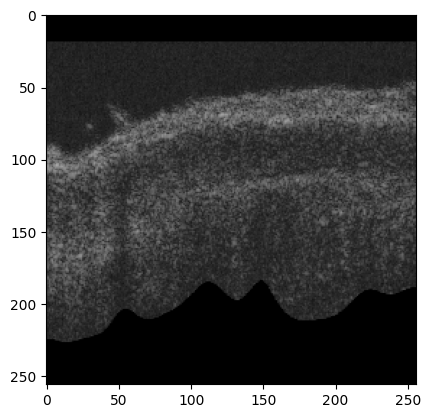

In [80]:
#Squeeze in x direction by factor of 2
# new_h,new_w = img.shape[0], int(img.shape[1]/2);
#Actually, lets set it to the final target width of 256 if we're already resizing.
new_h,new_w = 256,256;
resized = cv2.resize(cropped_img, (new_w,new_h), interpolation = cv2.INTER_AREA)
showImg(resized)

#Show original (left) next to processed (right) images:

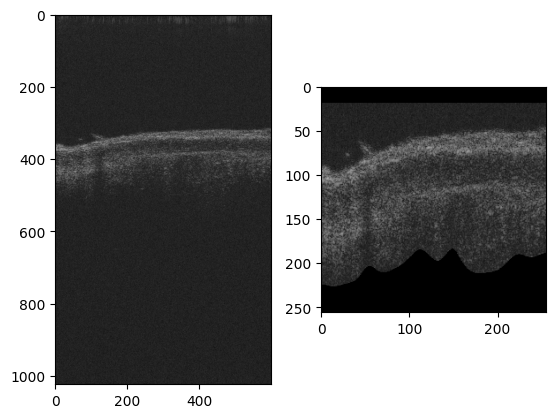

In [81]:
#show processed image next to the original image
img = readImgByPath(path_new_image)
showTwoImgs(img, resized)

# Save preprocessed image to file

---




In [82]:
#double the image in size, to match expected input
padded_resized = np.zeros([256,512,3], np.uint8)
padded_resized[:,:256,:] = resized[:,:,:]
#save image
output_dir_name="/content/test_folder/";
!mkdir {output_dir_name}
output_dir_name="/content/test_folder/test";
!mkdir {output_dir_name}
filename = f"{output_dir_name}/new_image_preprocessed.jpg"
cv2.imwrite(filename, padded_resized)

mkdir: cannot create directory ‘/content/test_folder/’: File exists
mkdir: cannot create directory ‘/content/test_folder/test’: File exists


True

## Run pix2pix

---




In [83]:
!python /content/pytorch-CycleGAN-and-pix2pix/test.py --netG resnet_9blocks --dataroot "/content/test_folder"  --model pix2pix --name pix2pix --checkpoints_dir "checkpoints" --results_dir "/content/new_results_folder"

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: checkpoints                   	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/test_folder          	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0   

#Show original (left) next to Virtual Histology output (right):

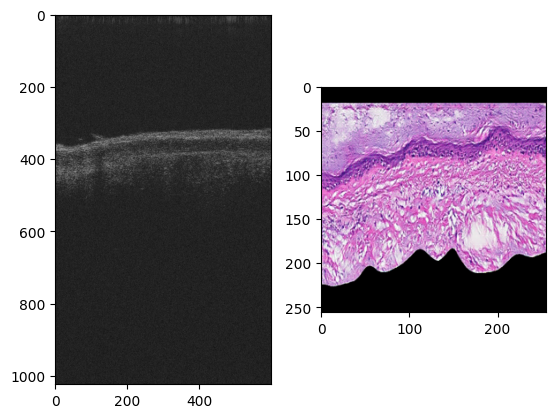

In [84]:
output_path = "/content/new_results_folder/pix2pix/test_latest/images/new_image_preprocessed_fake_B.png"
im1 = readImgByPath(path_new_image);
im2 = readImgByPath(output_path)
showTwoImgs(im1,im2)

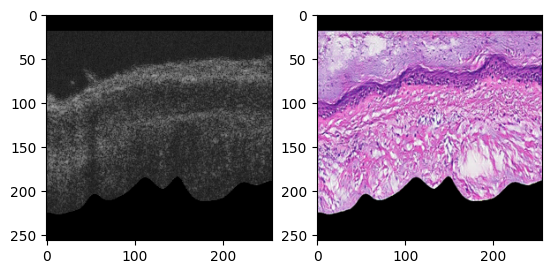

In [85]:
showTwoImgs(resized,im2)